# Recommendation System for Fashionable Clothing E-commerce

## This Recommendation System uses CNN and TL to create vector encoding for visual features of product and then vector search techniques for efficient recommended product retrieval.

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import json
from tqdm.notebook import tqdm
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array
import gc

Image: 30742.jpg, Shape: (2400, 1800, 3)
Image: 6175.jpg, Shape: (1440, 1080, 3)
Image: 50195.jpg, Shape: (1440, 1080, 3)
Image: 40155.jpg, Shape: (2400, 1800, 3)
Image: 24178.jpg, Shape: (1440, 1080, 3)
Image: 13726.jpg, Shape: (1440, 1080, 3)


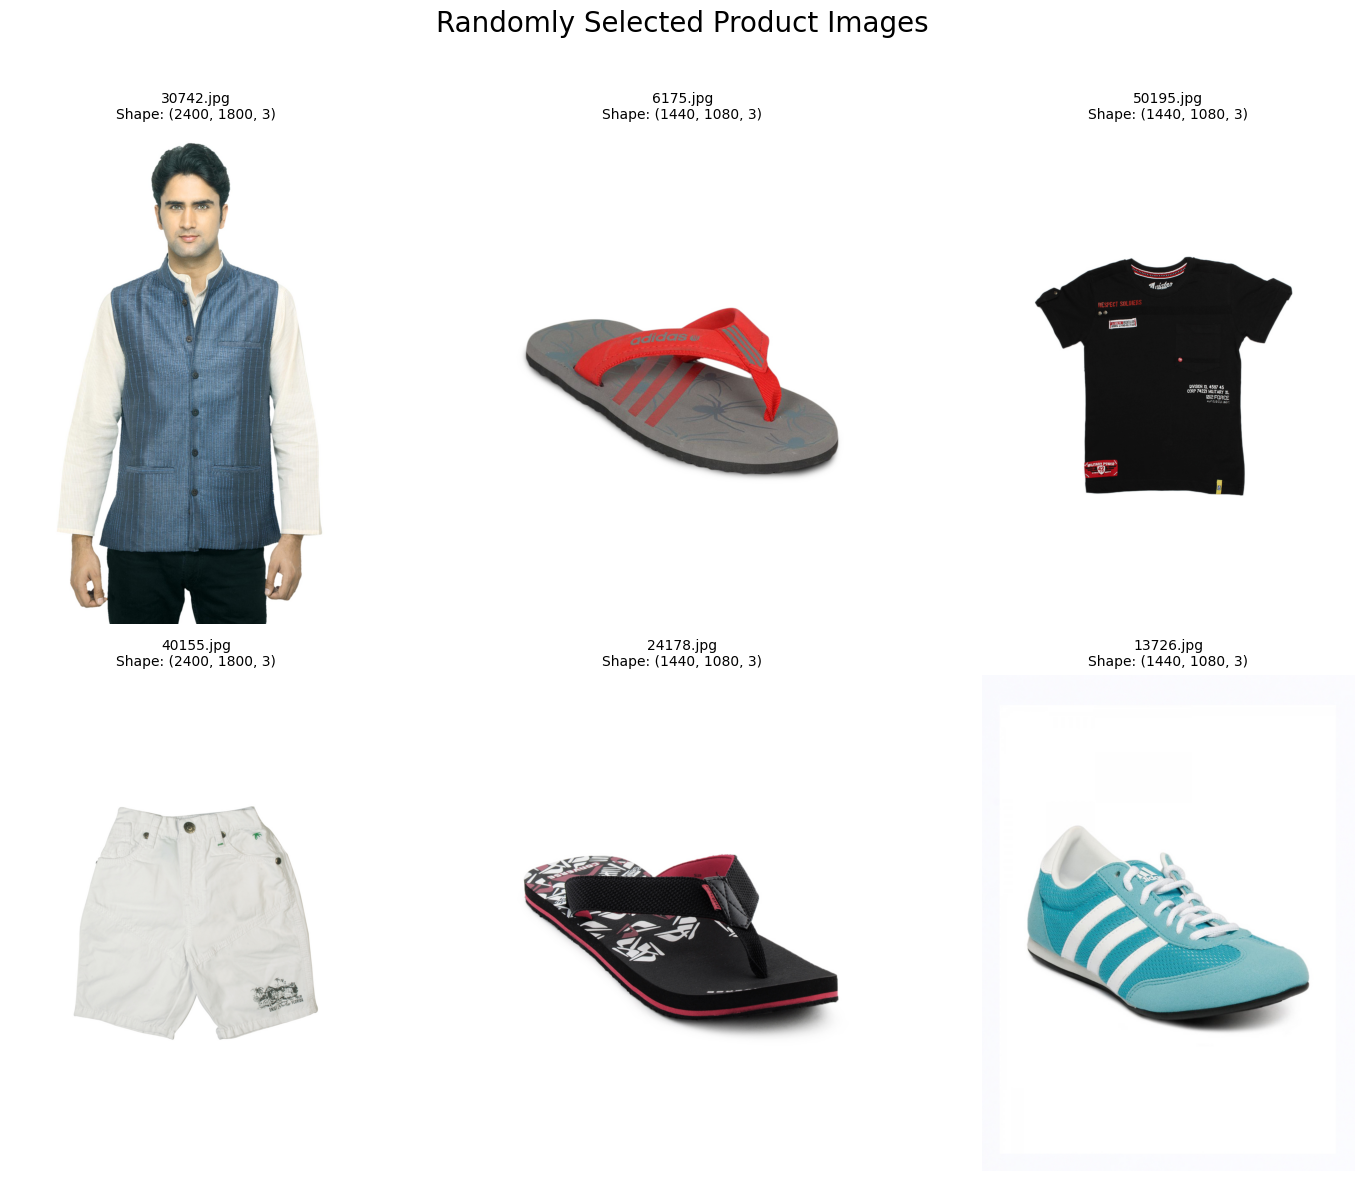

In [8]:
def display_random_images(image_dir, num_images=6, grid_rows=2, grid_cols=3):
    """
    Randomly selects, displays images from a directory in a grid, and shows their shapes.

    Args:
        image_dir (str): The path to the directory containing the images.
        num_images (int): The total number of random images to display.
        grid_rows (int): The number of rows in the display grid.
        grid_cols (int): The number of columns in the display grid.
    """
    try:
        # Get all image file paths 
        all_image_files = [
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))
        ]

        if not all_image_files:
            print(f"Error: No images found in the directory: {image_dir}")
            return

        if len(all_image_files) < num_images:
            print(f"Warning: Not enough images in the directory. Found {len(all_image_files)}, but need {num_images}.")
            num_images = len(all_image_files)

        random_image_files = random.sample(all_image_files, num_images)
        image_paths = [os.path.join(image_dir, f) for f in random_image_files]

        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 12)) # Increased height for titles
        

        axes = axes.flatten()

        fig.suptitle('Randomly Selected Product Images', fontsize=20)

        for i, img_path in enumerate(image_paths):
            try:
                with Image.open(img_path) as img:

                    img_array = np.array(img)
                    shape = img_array.shape
                    
                    print(f"Image: {os.path.basename(img_path)}, Shape: {shape}")

                    ax = axes[i]
                    ax.imshow(img)
                    
                    title_text = f"{os.path.basename(img_path)}\nShape: {shape}"
                    ax.set_title(title_text, fontsize=10)
                    ax.axis('off')
            except Exception as e:
                print(f"Could not open or display image {img_path}. Error: {e}")
                axes[i].axis('off')

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    except FileNotFoundError:
        print(f"Error: The directory was not found: {image_dir}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

image_directory_path = './data/images/' 

display_random_images('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images')

In [11]:
def get_image_shape_counts(image_dir, sample_size=10000):
    """
    Counts the occurrences of each unique image shape in a directory,
    using a random sample of images.

    Args:
        image_dir (str): The path to the directory containing the images.
        sample_size (int): The number of random images to sample for analysis.
    """
    try:
        all_image_files = [
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))
        ]

        if not all_image_files:
            print(f"Error: No images found in the directory: {image_dir}")
            return

        if len(all_image_files) > sample_size:
            print(f"Found {len(all_image_files)} total images. Analyzing a random sample of {sample_size}.")
            files_to_process = random.sample(all_image_files, sample_size)
        else:
            print(f"Found {len(all_image_files)} images. Analyzing all of them as it's less than the sample size.")
            files_to_process = all_image_files

        shape_counts = Counter()

        for filename in tqdm(files_to_process, desc="Processing Images"):
            try:
                img_path = os.path.join(image_dir, filename)
                with Image.open(img_path) as img:
                    img_array = np.array(img)
                    shape_counts[img_array.shape] += 1
            except Exception as e:
                print(f"Could not process image {filename}. Error: {e}")
        
        print("\n--- Image Shape Analysis Complete ---")
        if not shape_counts:
            print("No shapes were counted. There might have been issues reading the images.")
            return

        print(f"Found {len(shape_counts)} unique image shapes in the sample.")
        print("Shape (Height, Width, Channels) : Count")
        print("-" * 40)
        
        for shape, count in shape_counts.most_common():
            print(f"{shape} : {count}")

    except FileNotFoundError:
        print(f"Error: The directory was not found: {image_dir}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

image_directory_path = './data/images/'

get_image_shape_counts('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images')

Found 44441 total images. Analyzing a random sample of 10000.


Processing Images:   0%|          | 0/10000 [00:00<?, ?it/s]


--- Image Shape Analysis Complete ---
Found 16 unique image shapes in the sample.
Shape (Height, Width, Channels) : Count
----------------------------------------
(1440, 1080, 3) : 5576
(2400, 1800, 3) : 4370
(200, 150, 3) : 21
(480, 360, 3) : 15
(720, 540, 3) : 6
(2700, 2700, 3) : 2
(1600, 1200, 3) : 1
(3256, 2442, 3) : 1
(2400, 1799, 3) : 1
(3216, 2136, 3) : 1
(2297, 1800, 3) : 1
(1456, 1101, 3) : 1
(3264, 2448, 3) : 1
(3888, 2592, 3) : 1
(5616, 3744, 3) : 1
(2401, 1800, 3) : 1


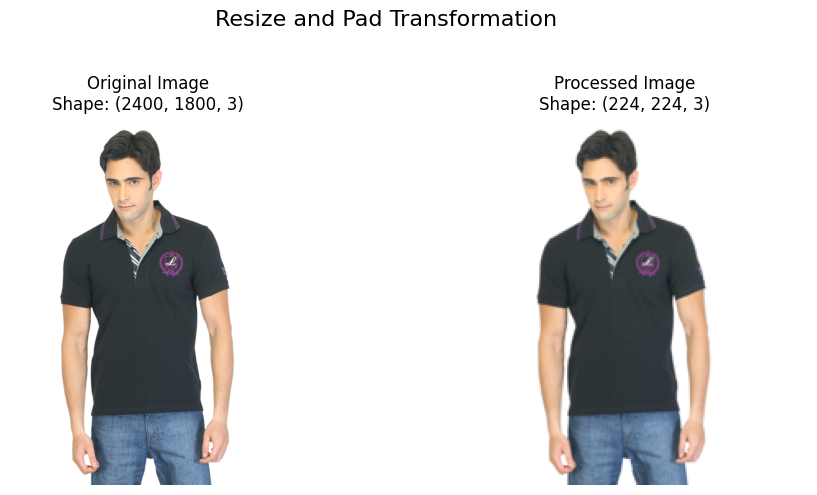

In [14]:
def resize_and_pad_image(image_path, output_size=(224, 224), background_color=(255,255,255)):
    """
    Resizes an image to a target output size while maintaining its aspect ratio
    by padding the background.

    Args:
        image_path (str): The path to the input image.
        output_size (tuple): The target (width, height) of the output image.
        background_color (tuple): The RGB color to use for padding.

    Returns:
        PIL.Image.Image: The processed image.
    """
    try:
        img = Image.open(image_path).convert("RGB")

        img.thumbnail(output_size)

        padded_img = Image.new("RGB", output_size, background_color)

        paste_x = (output_size[0] - img.width) // 2
        paste_y = (output_size[1] - img.height) // 2
        
        padded_img.paste(img, (paste_x, paste_y))

        return padded_img

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None
    except Exception as e:
        print(f"An error occurred while processing {image_path}: {e}")
        return None


image_directory_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images'
try:
    all_image_files = [
        f for f in os.listdir(image_directory_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]
    if all_image_files:
        random_image_file = random.choice(all_image_files)
        example_image_path = os.path.join(image_directory_path, random_image_file)

        target_size = (224, 224)
        processed_image = resize_and_pad_image(example_image_path, output_size=target_size)

        if processed_image:
            original_image = Image.open(example_image_path)

            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            
            # Original Image
            axes[0].imshow(original_image)
            axes[0].set_title(f"Original Image\nShape: {np.array(original_image).shape}")
            axes[0].axis('off')

            # Processed Image
            axes[1].imshow(processed_image)
            axes[1].set_title(f"Processed Image\nShape: {np.array(processed_image).shape}")
            axes[1].axis('off')

            plt.suptitle("Resize and Pad Transformation", fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

    else:
        print(f"No images found in '{image_directory_path}' to demonstrate.")

except FileNotFoundError:
    print(f"Error: The directory was not found: {image_directory_path}")
except Exception as e:
    print(f"An unexpected error occurred during the example usage: {e}")


2025-08-05 14:09:45.514023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754402985.723914      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754402985.789565      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading pre-trained EfficientNetB0 model...


I0000 00:00:1754402998.552544      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754402998.553241      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model loaded successfully. Embedding size: 1280

Generating embedding for a random image: 47268.jpg


I0000 00:00:1754403005.296763     102 service.cc:148] XLA service 0x7ae4a8003400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754403005.297565     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754403005.297586     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754403005.986967     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


I0000 00:00:1754403010.332650     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Successfully generated embedding.
Shape of the embedding: (1280,)
First 10 values of the embedding vector:
[-0.11081416  0.02220091 -0.06446215  1.0646577  -0.08294643 -0.09230078
 -0.14025226 -0.00394814 -0.01889358  0.02383352]


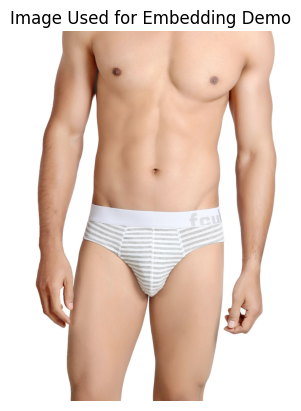

In [1]:
def create_embedding_model():
    """
    Initializes the EfficientNetB0 model for feature extraction.
    
    Returns:
        A Keras model that takes an image as input and outputs its embedding.
    """
    print("Loading pre-trained EfficientNetB0 model...")
    base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
    
    base_model.trainable = False

    print(f"Model loaded successfully. Embedding size: {base_model.output_shape[1]}")
    return base_model


def get_embedding(model, image_path):
    """
    Processes an image and generates its embedding using the provided model.

    Args:
        model (tf.keras.Model): The pre-trained model for feature extraction.
        image_path (str): The path to the image file.

    Returns:
        np.ndarray: The embedding vector for the image.
    """
    try:
        original_image = Image.open(image_path).convert("RGB")
        processed_image = resize_and_pad_image(original_image)
        image_array = img_to_array(processed_image)
        image_array = np.expand_dims(image_array, axis=0)
        preprocessed_input = tf.keras.applications.efficientnet.preprocess_input(image_array)
        embedding = model.predict(preprocessed_input)
        return embedding.flatten()

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None
    except Exception as e:
        print(f"An error occurred while generating embedding for {image_path}: {e}")
        return None


embedding_model = create_embedding_model()
image_directory_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images'
try:
    all_image_files = [f for f in os.listdir(image_directory_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if all_image_files:
        random_image_file = random.choice(all_image_files)
        example_image_path = os.path.join(image_directory_path, random_image_file)

        print(f"\nGenerating embedding for a random image: {random_image_file}")
        example_embedding = get_embedding(embedding_model, example_image_path)

        if example_embedding is not None:
            print(f"\nSuccessfully generated embedding.")
            print(f"Shape of the embedding: {example_embedding.shape}")
            print("First 10 values of the embedding vector:")
            print(example_embedding[:10])
            
            # Display the image we just processed
            plt.imshow(Image.open(example_image_path))
            plt.title(f"Image Used for Embedding Demo")
            plt.axis('off')
            plt.show()

    else:
        print(f"No images found in '{image_directory_path}' to demonstrate.")

except FileNotFoundError:
    print(f"Error: The directory was not found: {image_directory_path}")
except Exception as e:
    print(f"An unexpected error occurred during the example usage: {e}")


In [ ]:
def create_embedding_model(embedding_dim=512):
    """
    Initializes the EfficientNetB0 model and adds a Dense layer to reduce
    the embedding dimension.
    
    Args:
        embedding_dim (int): The desired final dimension for the embedding vector.

    Returns:
        A Keras model that takes an image as input and outputs its embedding.
    """
    print("Loading pre-trained EfficientNetB0 model...")
    # Load the base model without the top layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
    base_model.trainable = False

    # Add a new Dense layer for dimensionality reduction 
    # This takes the 1280-dim output from EfficientNetB0 and projects it to 512-dim
    inputs = base_model.input
    x = base_model.output
    # The new Dense layer will output a vector of size `embedding_dim`
    outputs = Dense(embedding_dim, activation=None)(x)

    # Create the final model
    model = Model(inputs=inputs, outputs=outputs)
    
    print(f"Model loaded successfully. New embedding size: {model.output_shape[1]}")
    return model

def get_embedding(model, image_path):
    """
    Processes an image and generates its embedding using the provided model.
    """
    try:
        original_image = Image.open(image_path).convert("RGB")
        processed_image = resize_and_pad_image(original_image)
        image_array = img_to_array(processed_image)
        image_array = np.expand_dims(image_array, axis=0)
        preprocessed_input = tf.keras.applications.efficientnet.preprocess_input(image_array)
        embedding = model.predict(preprocessed_input)
        return embedding.flatten()
    except Exception as e:
        # We return None on failure so the main loop can skip this file
        print(f"Error processing {os.path.basename(image_path)}: {e}")
        return None

# Main Processing Script 
def process_all_images(image_dir, output_dir, model):
    """
    Processes all images in a directory, generates embeddings, and saves them as JSON files.
    """
    os.makedirs(output_dir, exist_ok=True)
    print(f"Embeddings will be saved to: {output_dir}")

    all_image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Found {len(all_image_files)} images to process.")

    for filename in tqdm(all_image_files, desc="Generating Embeddings"):
        image_path = os.path.join(image_dir, filename)
        
        embedding_vector = get_embedding(model, image_path)
        if embedding_vector is None:
            continue
            
        file_id = os.path.splitext(filename)[0]
        
        output_data = {
            "id": file_id,
            "embedding": embedding_vector.tolist() 
        }
        
        json_filename = f"{file_id}.json"
        output_path = os.path.join(output_dir, json_filename)
        
        with open(output_path, 'w') as f:
            json.dump(output_data, f)
            
        del embedding_vector
        del output_data
        
    gc.collect()
    print("\nProcessing complete.")


embedding_model = create_embedding_model(embedding_dim=512)

image_directory_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images'
output_embeddings_path = './embeddings/'

process_all_images(image_directory_path, output_embeddings_path, embedding_model)



2025-08-05 15:01:43.267631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754406103.623038      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754406103.729286      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Verifying GPU Availability ---


I0000 00:00:1754406121.718702      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754406121.719538      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2 physical GPUs, 2 logical GPUs.
GPU is available and will be used.
------------------------------
Loading pre-trained EfficientNetB0 model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model loaded successfully. New embedding size: 512
Embeddings will be saved to: ./embeddings/
Found 44441 images to process.


Generating Embeddings:   0%|          | 0/44441 [00:00<?, ?it/s]

I0000 00:00:1754406129.236352     100 service.cc:148] XLA service 0x78c3f80047e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754406129.238114     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754406129.238139     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754406130.016887     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

I0000 00:00:1754406135.141240     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

In [5]:
import shutil
import math

def format_size(size_bytes):
    """
    Converts a size in bytes to a human-readable string (KB, MB, GB, etc.).
    """
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return f"{s} {size_name[i]}"

def get_folder_stats(folder_path):
    """
    Calculates the total number of files and the total size of a folder.

    Args:
        folder_path (str): The path to the folder to analyze.
    """
    try:
        file_count = 0
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(folder_path):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                if os.path.isfile(fp):
                    file_count += 1
                    total_size += os.path.getsize(fp)
        return file_count, total_size
    except FileNotFoundError:
        print(f"Error: The directory was not found: {folder_path}")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None

def zip_folder(folder_path, output_path):
    """
    Creates a zip archive of a specified folder.

    Args:
        folder_path (str): The path to the folder to be zipped.
        output_path (str): The path for the output zip file (e.g., 'embeddings.zip').
    """
    try:
        print(f"\nZipping folder: '{folder_path}'...")
        shutil.make_archive(output_path.replace('.zip', ''), 'zip', folder_path)
        print(f"Successfully created zip file: '{output_path}'")
    except FileNotFoundError:
        print(f"Error: The source folder was not found: {folder_path}")
    except Exception as e:
        print(f"An error occurred during zipping: {e}")



folder_to_check = './embeddings/'

count, size_in_bytes = get_folder_stats(folder_to_check)

if count is not None and size_in_bytes is not None:
    print(f"--- Statistics for Folder: '{folder_to_check}' ---")
    print(f"Total number of files: {count}")
    print(f"Total size on disk: {format_size(size_in_bytes)} ({size_in_bytes} bytes)")

zip_file_name = 'embeddings.zip'
zip_folder(folder_to_check, zip_file_name)



--- Statistics for Folder: './embeddings/' ---
Total number of files: 44441
Total size on disk: 458.21 MB (480471235 bytes)

Zipping folder: './embeddings/'...
Successfully created zip file: 'embeddings.zip'
